## Modules

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
 
from datetime import datetime, timedelta
from itertools import product
from scipy.stats import norm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## Binary game Simulation

### Fixed-percent-betting simulation

In [2]:
def getSim_binaryFixPct(initAmount=100, f=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """
    Obtain dictionary of equal-percent-bet simulation results.
    initAmount: initial amount for betting
    f: percent per bet
    p: winning probability
    b: reward-to-risk ratio (/ odds)
    numTrialss: number of trials of the same binary game
    numSim: number of binary simulations
    """
    # Dict for recording different series of profit/loss
    simDict = {}
    # Dict for recording different series of capital (total equity)
    amountDict = {}
    # Generate a total of `numSim`= N series of binary game result and P/L
    stepFunc = lambda x: 1 if x > 0 else 0  # Lambda Function for getting "1" with a fixed prob and "0" otherwise
    for num in range(numSim):
        # Generate a series of "1"/"0" with probability p
        signArray = np.array([stepFunc(r) for r in np.random.uniform(p - 1, p, numTrials)])
        # Series of asset growth factor based on win/loss result (EITHER (1 + b * f%) OR (1 -f%))
        trialArray = 1 + f * ((b + 1) * signArray - 1) / 100
        # Record the asset growth factor series into `simDict`
        simDict[num + 1] = trialArray
        # Array of total equity and record into `amountDict`
        amountDict[f's{num + 1}'] = initAmount * trialArray.cumprod()
    # Form dataframe from the `amountDict` and transpose, so that each row corresponds to a betting series
    dfSim = pd.DataFrame(amountDict).transpose()
    # Rename columns so that each number in column labels corresponds to the k-th trial
    dfSim = dfSim.rename(columns={k: (k + 1) for k in dfSim.columns})

    return dfSim

### Performance KPIs: winning rate, RRR (Realized reward-risk ratio), profit factor

In [3]:
def getProfitfactor(p, b):
    """Get profit factor of a binary game."""
    return round(p * b / (1 - p), 4)

def getOdds(p, pf):
    """Given fixed winning rate and profit factor, find odds (or reward-risk ratio)."""
    return pf * (1 - p) / p

def getWinrate(b, pf):
    """Given fixed odds and profit factor, find winning rate."""   
    return pf / (pf + b)

### Sample of 20 fixed-percent-betting simulations of 12 trials

In [4]:
initAmount0 = 100  # Initial capital
f0 = 20  # Fixed amount per bet
p0 = 0.5   # winning probability
b0 = 1.6   # reward-risk ratio / odds
numTrials0 = 12 # Number of trials
numSim0 = 10  # Number of simulations (how many people keep playing same game for 12 runs)

pf0 = round(getProfitfactor(p0, b0), 4)
print(f'Profit Factor = {pf0}')

dfSim0 = np.round(getSim_binaryFixPct(initAmount0, f0, p0, b0, numTrials0, numSim0), 2)
dfSim0

Profit Factor = 1.6


,1,2,3,4,5,6,7,8,9,10,11,12
s1,132.0,105.60,84.48,111.51,147.20,194.30,256.48,338.55,446.89,589.89,778.66,1027.83
s2,132.0,105.60,139.39,184.00,147.20,117.76,94.21,75.37,99.48,131.32,173.34,138.67
s3,80.0,105.60,139.39,111.51,147.20,194.30,155.44,205.18,270.84,357.51,286.01,377.53
s4,80.0,64.00,51.20,67.58,54.07,71.37,57.09,45.68,60.29,48.23,63.67,84.04
s5,132.0,105.60,84.48,111.51,147.20,117.76,155.44,124.35,99.48,131.32,173.34,138.67
s6,132.0,174.24,230.00,184.00,242.88,194.30,256.48,338.55,446.89,357.51,286.01,377.53
s7,132.0,105.60,84.48,67.58,54.07,71.37,57.09,75.37,60.29,79.59,105.05,84.04
s8,80.0,64.00,84.48,67.58,89.21,71.37,57.09,75.37,99.48,79.59,105.05,138.67
s9,132.0,105.60,84.48,67.58,89.21,71.37,57.09,45.68,60.29,48.23,63.67,50.93
s10,132.0,105.60,139.39,111.51,89.21,117.76,155.44,205.18,164.15,131.32,173.34,228.81


## Equity curve plotting

### Simulation KPI

In [5]:
def getSimKPI_discretePL(simFunc, initAmount=100, f=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """Obtain a dictionary of final performance KPI of simulations. """
    dfSim = simFunc(initAmount, f, p, b, numTrials, numSim)
    dictKPI = {}
    dictKPI['p'] = p
    dictKPI['b'] = b
    dictKPI['f'] = f
    dictKPI['profitfactor'] = round(getProfitfactor(p, b), 4)
    dictKPI['win%'] = round(100 * dfSim[dfSim[numTrials] >= initAmount].shape[0] / numSim, 2)
    dictKPI['avgAmount'] = round(dfSim[numTrials].mean(), 2)
    dictKPI['midAmount'] = round(dfSim[numTrials].median(), 2)
    dictKPI['stdAmount'] = round(dfSim[numTrials].std(), 2)

    return dfSim, dictKPI

### Standard sample: p = 0.4, b = 2.0

In [6]:
initAmount1 = 100  
f1 = 10  
p1 = 0.4   
b1 = 2.0   
numTrial1 = 50 
numSim1 = 1000  

dfSim1, dictKPI1 = getSimKPI_discretePL(getSim_binaryFixPct, initAmount1, f1, p1, b1, numTrial1, numSim1)
dictKPI1

{'p': 0.4,
 'b': 2.0,
 'f': 10,
 'profitfactor': 1.3333,
 'win%': 63.6,
 'avgAmount': 250.95,
 'midAmount': 162.52,
 'stdAmount': 285.38}

### Function

In [7]:
def plotSim_discretePL(simFunc, initAmount=100, f=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """Plot equity curves from the betting simulations."""
    # Dataframe and KPI dict from `getSimKPI_discretePL()` function
    dfSim, dictKPI = getSimKPI_discretePL(simFunc, initAmount, f, p, b, numTrials, numSim)
    # First line of diagram title
    title = f'{numSim} simulations of {numTrials}-step binary game \n'
    title += f'Winning rate {round(p, 4)}, odds {round(b, 4)}, {f}% per bet \n'

    # Percentage of final equity above or equal to initial amount
    winrate = dictKPI['win%']
    avgAmount = dictKPI['avgAmount']  # Arithmetic mean of final equity
    midAmount = dictKPI['midAmount']  # Median of final equity
    stdAmount = dictKPI['stdAmount']  # SD of final equity
    profitfactor = dictKPI['profitfactor']

    # Attach key stats to title text
    title += f'Profit factor: {profitfactor}, final winrate: {winrate}% \n'
    title += f'Final equity mean: {avgAmount}, median: {midAmount}, SD: {stdAmount}'

    # Plot figure & append title
    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(title, fontsize=12)

    # Transpose the equity dataframe to plot
    dfPlot = dfSim.transpose()

    # Adopt semi-log scale for fixed-percent-betting & linear scale for fixed-amount-betting
    plt.semilogy(dfPlot)
    plt.plot(dfPlot.index, np.repeat(initAmount, numTrials), color='black', linewidth=3, linestyle='dashed')
    plt.show()

### Sample of 1000 simulations of 50-trial fixed-percent-betting trials

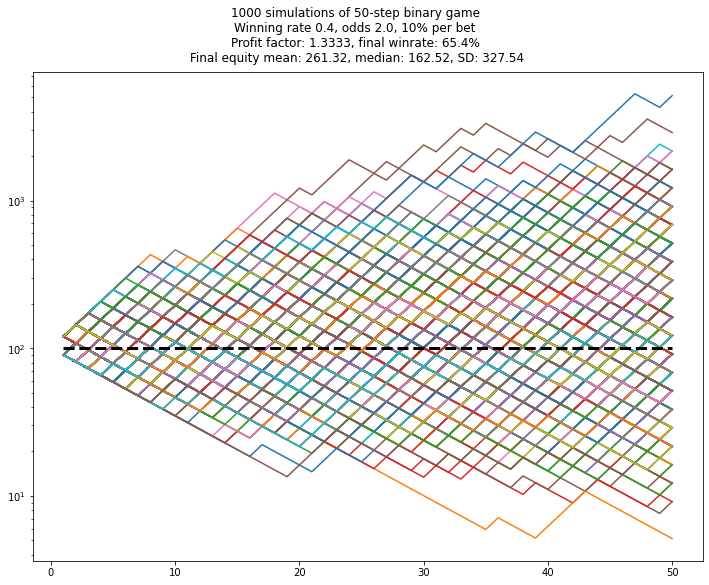

In [8]:
plotSim_discretePL(getSim_binaryFixPct, initAmount1, f1, p1, b1, numTrial1, numSim1)

### Raising winning rate & fix percent-per-bet, profit factor (odds reduced)

In [9]:
profitfactor1 = 4 / 3
p2 = 0.6   
b2 = getOdds(p2, profitfactor1)

plotSim_fixPctBet(initAmount1, f1, p2, b2, numTrial1, numSim1)

NameError: name 'plotSim_fixPctBet' is not defined

### Fix p & b, vary percent-per-bet

In [ ]:
f2 = 8
plotSim_fixPctBet(initAmount1, f2, p1, b1, numTrial1, numSim1)

In [ ]:
f3 = 20
plotSim_fixPctBet(initAmount1, f3, p1, b1, numTrial1, numSim1)

## Risk control & ruin

### percent ruin function

In [ ]:
def getRuin(dfSim, initAmount=100, numTrial=50, level=0.1):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""   
    return dfSim[dfSim[numTrial] <= level*initAmount].shape[0] / dfSim.shape[0]

### Using above (p, b) pair and vary number of trials & ruin level

In [ ]:
arrLevel = np.arange(0.05, 0.55, 0.05)  ## equity threshold level from 5% to 25%
arrTrial = range(50, 300, 50)  ## Number of betting trials from 50 to 250

dfRuin1 = pd.DataFrame(columns=arrTrial, index=arrLevel)

for numTrial, level in product(arrTrial, arrLevel):
    dfSim = getSim_fixPctBet(initAmount1, f1, p1, b1, numTrial, numSim1)
    dfRuin1.loc[level, numTrial] = getRuin(dfSim, initAmount1, numTrial, level)

print(f'% of final equity below X% of initial for f = {f1}%: \n\n {dfRuin1}')

### MDD function

In [ ]:
def getSimMDD(dfSim, levelsMDD=(0.2, 0.5, 0.8, 0.9)):
    """Obtain percentage of simulations with final amount dropping below the given equity threshold."""
    # Transpose the simulation dataframe
    dfSimT = dfSim.transpose()
    numTrial = dfSim.shape[1]
    numSim = dfSim.shape[0]
    # Compute MDD
    dfMDD = pd.DataFrame(columns=dfSimT.columns)
    for col in dfSimT.columns:
        dfMDD[col] = (dfSimT[col] / dfSimT[col].cummax() - 1).cummin()
    # Tranpose back to match original shape
    dfMDD = dfMDD.transpose()
    # Compute percentage of simulations having MDD greater than the levels
    dictMDD = {}
    for value in levelsMDD:
        dictMDD[value] = dfMDD[dfMDD[numTrial] <= -value].shape[0] / numSim

    return dfMDD, dictMDD   

In [ ]:
dfMDD1, dictMDD1 = getSimMDD(dfSim1)
print(f'Percentage of betting series suffering \n')

for key, value in dictMDD1.items():
    print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')

### Fix p, b and raise f to 20%

In [ ]:
dfSim2, dictKPI2 = getSimKPI_fixPctBet(initAmount1, f3, p1, b1, numTrial1, numSim1)
for key, value in dictKPI2.items():
    print(f'{key}: {value}')

dfRuin2 = pd.DataFrame(columns=arrTrial, index=arrLevel)

for numTrial, level in product(arrTrial, arrLevel):
    dfSim = getSim_fixPctBet(initAmount1, f3, p1, b1, numTrial, numSim1)
    dfRuin2.loc[level, numTrial] = getRuin(dfSim, initAmount1, numTrial, level)

print(f'\nPercentage of final equity below X% of initial for f = {f1}%: \n\n {dfRuin2}')

dfMDD2, dictMDD2 = getSimMDD(dfSim2)

print(f'\nPercentage of betting series suffering \n')

for key, value in dictMDD2.items():
    print(f'{round(100*key)}% MDD: {round(100*value, 2)}%')

## Optimal f% / Kelly Formula

### Expected geometric growth (= 1 + percentage-return)

In [ ]:
def getExpGrowth(p=0.5, b=1.5, f=0.1, n=1):
    """
    Obtain expected geometric return of repeated trials of a binary game.
    p: winning rate
    b: odds / reward-risk-ratio
    f: fixed percent of each bet
    n: number of trials
    """
    logGrowth = p * np.log(1 + b * f) + (1 - p) * np.log(1 - f)
    
    return np.exp(n * logGrowth)

def plotExpGrowth(p=0.5, b=1.5, n=1, fMin=0, fMax=0.5, step=0.01):
    """Plot expected geometric growth given fixed winning rate & odds, and identify optimal f%."""
    # Form pandas Series of expected return of varying f%
    arrFpct = np.arange(fMin, fMax, step)
    dictGrowth = {f: getExpGrowth(p, b, f, n) - 1 for f in arrFpct}
    dfGrowth = pd.DataFrame(pd.Series(dictGrowth))
    # Plot interactive diagram of f-percent curve
    fig = px.line(x=dfGrowth.index, y=dfGrowth[0], labels={'x': 'f%', 'y': f'%return on {n} trials'})
    fig.add_trace(go.Scatter(x=dfGrowth.index, y=np.repeat(0, len(arrFpct)), name='0%'))
    # Identify optimal f%
    bestF = dfGrowth[0].idxmax()
    bestGrowth = dfGrowth[0].max()
    fig.add_trace(go.Scatter(x=(bestF, ), y=(bestGrowth, ), line_color='green', name='Opt-f%', mode='markers+text', 
                             marker_size=10, text=f'{bestF, round(bestGrowth, 4)}', textposition='bottom center'))
    
    # Show diagram
    fig.show()

### Example 1 (adopt above example p1 = 0.4, b1 = 2.0)

In [ ]:
plotExpGrowth(p1, b1, n=50)

### Example 2 (Fix b = 2.0, improve p to 0.5, and reduce to 10 trials)

In [ ]:
p4 = 0.5
b4 = 2.0
plotExpGrowth(p4, b4, n=10)

### Example 3 (Fix profit factor in eg.1 [4 / 3] and raise p to 0.6)

In [ ]:
b2 = getOdds(p2, profitfactor1)
plotExpGrowth(p2, b2, n=50)

### Kelly formula (for discrete binary game ONLY)

In [ ]:
def getKellyF(p, b):
    """Obtain the optimal f% by Kelly formula."""
    return round(max((p * b - 1 + p) / b, 0), 4)

### Kelly f% value for a bunch of (p, b) pair

In [ ]:
arrP = np.arange(0.2, 0.85, 0.05)
arrB = np.arange(0.5, 4.25, 0.25)

dfKelly = pd.DataFrame()

for p, b in product(arrP, arrB):
    dfKelly.loc[b, f'{round(100*p, 2)}%'] = f'{round(100 * getKellyF(p, b), 2)}%'

dfKelly

### Profit factor corresponding to above (p, b) pairs

In [ ]:
dfProfitfactor = pd.DataFrame()

for p, b in product(arrP, arrB):
    dfProfitfactor.loc[b, f'{round(100*p, 2)}%'] = float(f'{round(getProfitfactor(p, b), 2)}')

dfProfitfactor

### Expected growth using kelly-f%, half-kelly and 2x-kelly

- Frequency inversely proportional to profit factor (trichotomy of win%, odds & frequency)

In [ ]:
dfGrowth1 = pd.DataFrame()
dfGrowth2 = pd.DataFrame()
dfGrowth3 = pd.DataFrame()

numTrade = 50

for p, b in product(arrP, arrB):
    optF = dfKelly.loc[b, f'{round(100*p, 2)}%']
    optF = float(optF[:-1]) / 100
    pf = dfProfitfactor.loc[b, f'{round(100*p, 2)}%']
    n = int(numTrade / max(pf, 1))
    dfGrowth1.loc[b, f'{round(100*p, 2)}%'] = round(initAmount1 * getExpGrowth(p, b, optF, n), 2)
    dfGrowth2.loc[b, f'{round(100*p, 2)}%'] = round(initAmount1 * getExpGrowth(p, b, optF / 2, n), 2)
    dfGrowth3.loc[b, f'{round(100*p, 2)}%'] = round(initAmount1 * getExpGrowth(p, b, min([optF * 2, 0.999]), n), 2)

dfGrowth1

In [ ]:
dfGrowth2

In [ ]:
dfGrowth3

## Diversification of almost-uncorrelated betting series and kelly-f%

### Example: kelly-f% and half-kelly-f% for 5 distinct betting strategies with varying (p, b)

In [ ]:
pList = [0.4, 0.55, 0.35, 0.6, 0.45]
profitfactorList = [1.8, 1.65, 1.25, 2.0, 1.4]
bList = [round(getOdds(p, pf), 4) for p, pf in zip(pList, profitfactorList)]
print(f'Odds list: {bList}')

fList_opt = [round(getKellyF(p, b) * 100, 4) for p, b in zip(pList, bList)]
fList_half = [round(f / 2, 4) for f in fList_opt]
print(f'Kelly-opt-f% list: {fList_opt}')
print(f'Half-Kelly-f% list: {fList_half}')


### Generate 400 simulations of 50-trial binary game equity dataframe with kelly f%

In [ ]:
list_dfSim1 = []
list_dfSim2 = []

initAmount2 = 100
numTrial2 = 50
numSim2 = 400

dfKPI1 = pd.DataFrame()
dfKPI2 = pd.DataFrame()

for p, b, f in zip(pList, bList, fList_opt):
    dfSim1, dictKPI1 = getSimKPI_fixPctBet(initAmount2, f1, p, b, numTrial2, numSim2)
    dfSim2, dictKPI2 = getSimKPI_fixPctBet(initAmount2, f1 / 2, p, b, numTrial2, numSim2)
    list_dfSim1.append(dfSim1)
    list_dfSim2.append(dfSim2)
    dfKPI1 = dfKPI1.append(dictKPI1, ignore_index=True)
    dfKPI2 = dfKPI2.append(dictKPI2, ignore_index=True)    
    
dfKPI1.rename(index={num: f'strat{num+1}' for num in range(5)}, inplace=True)
dfKPI2.rename(index={num: f'strat{num+1}' for num in range(5)}, inplace=True)

### Performance KPI for kelly-f% and MDD stat

In [ ]:
levelsMDD0 = [0.1, 0.2, 0.5, 0.8]

dfMDDStat1 = pd.DataFrame(columns=levelsMDD0)

for df in list_dfSim1:
    dfMDD, dictMDD = getSimMDD(df, levelsMDD0)
    dfMDDStat1 = dfMDDStat1.append(dictMDD, ignore_index=True)
    
dfMDDStat1.rename(index={num: f'strat{num+1}' for num in range(5)}, inplace=True)

print(f'% of betting series suffering X% MDD under opt-f%: \n\n{dfMDDStat1}')

dfKPI1

### Performance KPI for half-kelly-f%

In [ ]:
dfMDDStat2 = pd.DataFrame(columns=levelsMDD0)

for df in list_dfSim2:
    dfMDD, dictMDD = getSimMDD(df, levelsMDD0)
    dfMDDStat2 = dfMDDStat2.append(dictMDD, ignore_index=True)
    
dfMDDStat2.rename(index={num: f'strat{num+1}' for num in range(5)}, inplace=True)

print(f'% of betting series suffering X% MDD under opt-f%: \n\n{dfMDDStat2}')

dfKPI2

### Use equal-weighted allocation to obtain 400 simulations of strategy portfolio

In [ ]:
weightList = [0.2] * 5

dfSim_All1 = sum([dfSim * weight for dfSim, weight in zip(list_dfSim1, weightList)]) 
dfSim_All2 = sum([dfSim * weight for dfSim, weight in zip(list_dfSim2, weightList)]) 

dfSim_All1.iloc[:10, -5:]

### KPI for first portfolio (of 5 kelly-f% strats) & compare to cell[33]

In [ ]:
# Performance KPIs of kelly-f% portfolio
dictKPI_All1 = {}

dictKPI_All1['win%'] = round(100 * dfSim_All1[dfSim_All1[numTrial2] >= initAmount2].shape[0] / numSim2, 2)
dictKPI_All1['avgAmount'] = round(dfSim_All1[numTrial2].mean(), 2)
dictKPI_All1['midAmount'] = round(dfSim_All1[numTrial2].median(), 2)
dictKPI_All1['stdAmount'] = round(dfSim_All1[numTrial2].std(), 2)      

# Performance KPIs of half-kelly-f% portfolio
dictKPI_All2 = {}

dictKPI_All2['win%'] = round(100 * dfSim_All2[dfSim_All2[numTrial2] >= initAmount2].shape[0] / numSim2, 2)
dictKPI_All2['avgAmount'] = round(dfSim_All2[numTrial2].mean(), 2)
dictKPI_All2['midAmount'] = round(dfSim_All2[numTrial2].median(), 2)
dictKPI_All2['stdAmount'] = round(dfSim_All2[numTrial2].std(), 2)      

# Combined
dfKPI_All = pd.DataFrame(columns=['win%', 'avgAmount', 'midAmount', 'stdAmount'])
dfKPI_All = dfKPI_All.append(dictKPI_All1, ignore_index=True)
dfKPI_All = dfKPI_All.append(dictKPI_All2, ignore_index=True)
dfKPI_All = dfKPI_All.transpose()
dfKPI_All = dfKPI_All.rename(columns={0: 'opt-f%', 1: 'half-opt-f%'})

# MDD stats
dfMDD_All1, dictMDD_All1 = getSimMDD(dfSim_All1, levelsMDD0)
dfMDD_All2, dictMDD_All2 = getSimMDD(dfSim_All2, levelsMDD0)

for key, value in dictMDD_All1.items():
    dfKPI_All.loc[f'%(Sim)_{round(key*100, 0)}%MDD', 'opt-f%'] = value
    
for key, value in dictMDD_All2.items():
    dfKPI_All.loc[f'%(Sim)_{round(key*100, 0)}%MDD', 'half-opt-f%'] = value
    
dfKPI_All


### Check correlation of random simulation (of same index number) of each strategy

In [ ]:
numStrat = np.random.randint(1, numSim2 + 1)

dfStrat = pd.DataFrame()
numIndex = 1

for df in list_dfSim1:
    dfStrat = pd.concat([dfStrat, df.loc[[f's{numStrat}']]], axis=0)
    dfStrat.rename(index={f's{numStrat}': f'strat{numIndex}'}, inplace=True)
    numIndex += 1
    
dfStrat = dfStrat.transpose()

for col, b, f in zip(dfStrat.columns, bList, fList_opt):
    dfStrat[col] = np.round(dfStrat[col] / dfStrat[col].shift(1), 4)

dfStrat.tail(10)

### Check correlation of returns

- For degree of freedom around 50, critical value of dependence (at sig level 0.05) is +/- 0.231
- IF corr coefficient lies in range (-0.231, 0.231), would accept that two series are independent

In [ ]:
dfStrat.corr()